In [ ]:
# Clone the Matterport library
# !git clone https://github.com/matterport/Mask_RCNN.git

In [ ]:
# use tensflow version 1.x
%tensorflow_version 1.x
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import random

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn.visualize import display_instances
from mrcnn import visualize
from mrcnn.model import log

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_WEIGHTS_PATH):
            utils.download_trained_weights(COCO_WEIGHTS_PATH)

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = '/content/drive/My Drive/mask-rcnn-car-damage-detection/logs'

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
class CustomConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "damage"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + toy

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 95% confidence
    DETECTION_MIN_CONFIDENCE = 0.95

In [ ]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("damage", 1, "damage")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "damage",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "damage":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "damage":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

# **Configurations**

In [ ]:
config = CustomConfig()
CUSTOM_DIR = '/content/drive/My Drive/mask-rcnn-car-damage-detection/'
print(CUSTOM_DIR)

/content/drive/My Drive/mask-rcnn-car-damage-detection/


# **Dataset**

In [ ]:
# To extract dataset folder from rar file
# !unrar x  "/content/drive/My Drive/mask-rcnn-car-damage-detection/Dataset1.rar"

In [ ]:

# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 49
Class Count: 2
  0. BG                                                
  1. damage                                            


# **Display Samples**

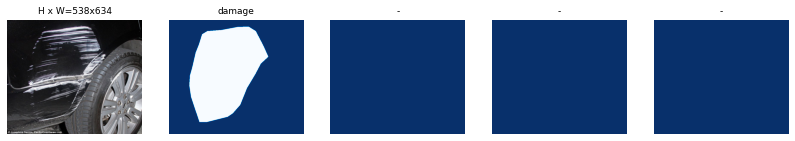

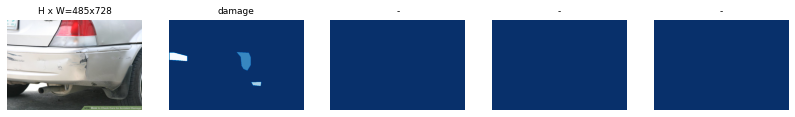

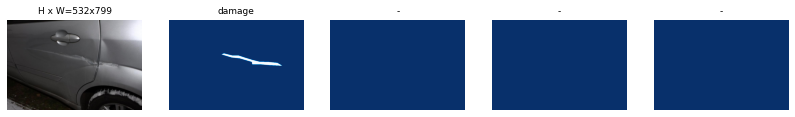

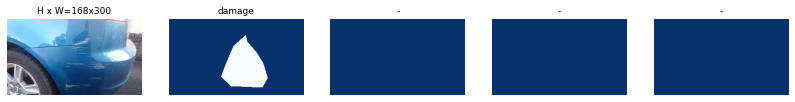

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# **Bounding Boxes**

image_id  42 /content/drive/My Drive/mask-rcnn-car-damage-detection/train/image7.jpg
image                    shape: (1200, 1600, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1200, 1600, 1)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  183.00000  max: 1064.00000  int32


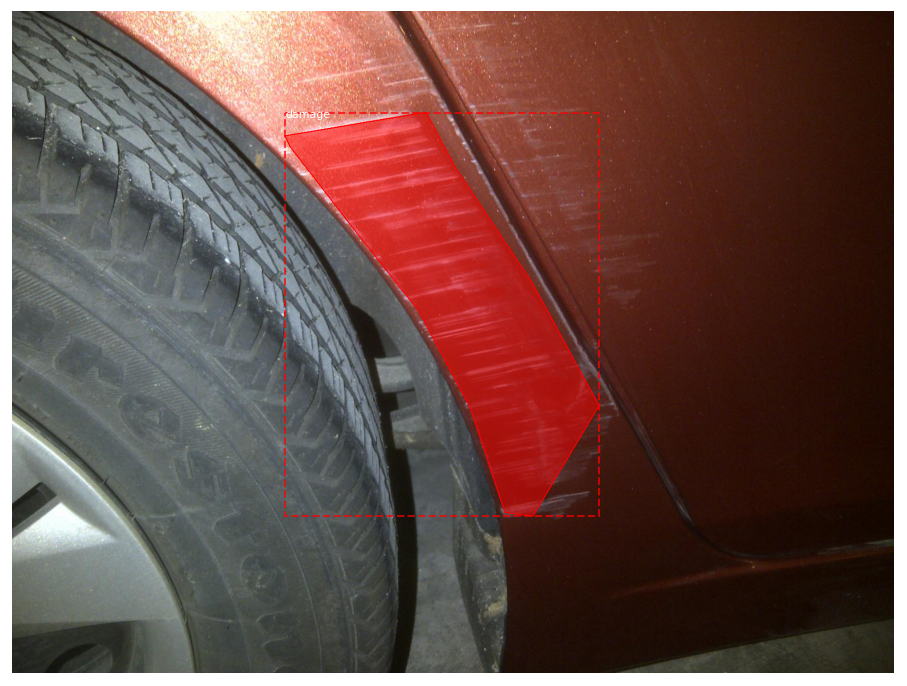

In [ ]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [ ]:
config = CustomConfig()
MODEL_DIR = '/content/drive/My Drive/mask-rcnn-car-damage-detection/logs/'

In [ ]:
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0
import tensorflow as tf
with tf.device(DEVICE):
  model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom(CUSTOM_DIR, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom(CUSTOM_DIR, "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=10,
                layers='heads')

In [ ]:
# !pip install keras==2.1.0

In [ ]:
train(model)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/mask-rcnn-car-damage-detection/logs/damage20200512T1023/mask_rcnn_damage_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistribu

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
 99/100 [============================>.] - ETA: 0s - loss: 2.2604 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 0.8329 - mrcnn_class_loss: 0.1611 - mrcnn_bbox_loss: 0.6748 - mrcnn_mask_loss: 0.5397

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



100/100 [==============================] - 164s 2s/step - loss: 2.2541 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 0.8278 - mrcnn_class_loss: 0.1600 - mrcnn_bbox_loss: 0.6754 - mrcnn_mask_loss: 0.5392 - val_loss: 1.6462 - val_rpn_class_loss: 0.0284 - val_rpn_bbox_loss: 0.4707 - val_mrcnn_class_loss: 0.0564 - val_mrcnn_bbox_loss: 0.6244 - val_mrcnn_mask_loss: 0.4663
Epoch 2/10
100/100 [==============================] - 84s 840ms/step - loss: 1.1341 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.2671 - mrcnn_class_loss: 0.0832 - mrcnn_bbox_loss: 0.3556 - mrcnn_mask_loss: 0.4021 - val_loss: 1.6946 - val_rpn_class_loss: 0.0279 - val_rpn_bbox_loss: 0.5355 - val_mrcnn_class_loss: 0.0515 - val_mrcnn_bbox_loss: 0.5902 - val_mrcnn_mask_loss: 0.4896
Epoch 3/10
100/100 [==============================] - 84s 837ms/step - loss: 0.8733 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.1701 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.2795 - mrcnn_mask_loss: 0.3304 - val_loss: 1.5210 - val_rpn_class_loss: 0

# **Inspecting the Trained Model**

In [ ]:
MODEL_DIR = "/content/drive/My Drive/mask-rcnn-car-damage-detection/logs/"

custom_WEIGHTS_PATH = "/content/drive/My Drive/mask-rcnn-car-damage-detection/logs/damage20200512T1023/mask_rcnn_damage_0010.h5"

# **Configuration**

In [ ]:
custom_DIR = '/content/drive/My Drive/mask-rcnn-car-damage-detection/'

In [ ]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(CustomConfig):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

infer_config = InferenceConfig()
infer_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [ ]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# **Load Validation Dataset**

In [ ]:
# Load validation dataset
dataset = CustomDataset()
dataset.load_custom(custom_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 15
Classes: ['BG', 'damage']


In [ ]:
# Create model in inference mode
import tensorflow as tf
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=infer_config)


In [ ]:
# Load weights
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)

Loading weights  /content/drive/My Drive/mask-rcnn-car-damage-detection/logs/damage20200512T1023/mask_rcnn_damage_0010.h5
Re-starting from epoch 10


In [ ]:
from importlib import reload # was constantly changin the visualization, so I decided to reload it instead of notebook
reload(visualize)

<module 'mrcnn.visualize' from '/content/Mask_RCNN/mrcnn/visualize.py'>

In [ ]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

image ID: damage.image72.jpeg (9) /content/drive/My Drive/mask-rcnn-car-damage-detection/val/image72.jpeg


In [ ]:
log("original_image", image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  349.00000  max:  772.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  349.00000  max:  772.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


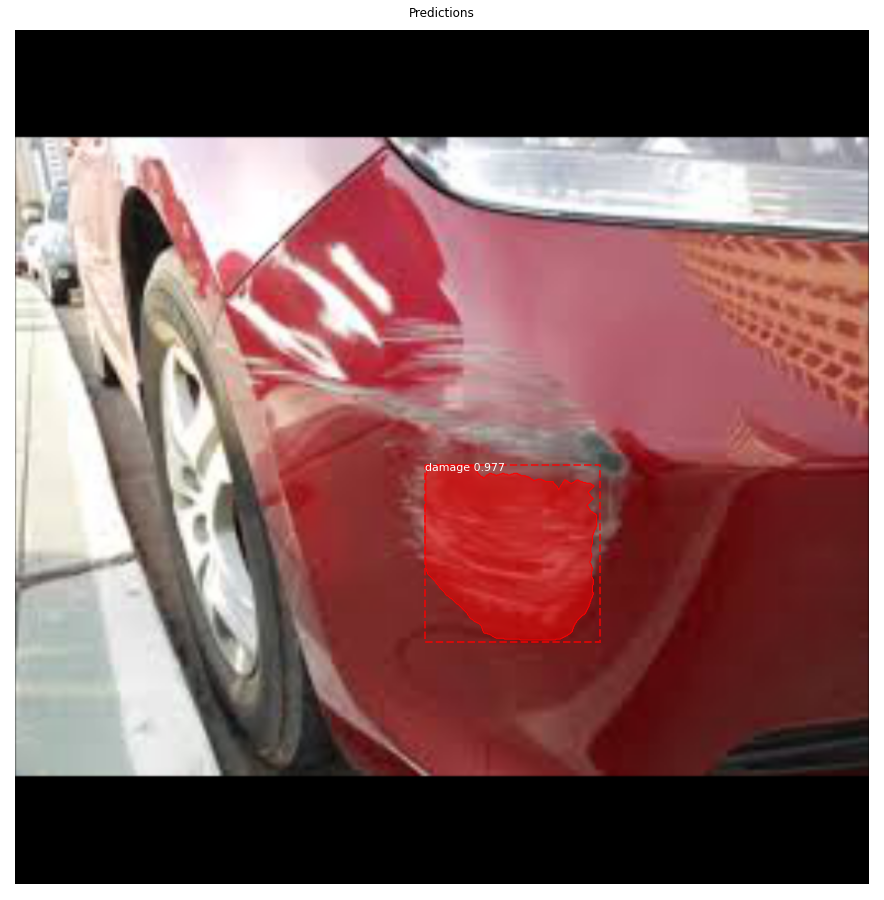

In [ ]:
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)